## Example of Duffing oscillator (Pytorch).
Use physics-informed neural network (PINN) to solve Duffing oscillator. <br>
The specific equation is as follows:

\begin{equation}
	\frac{d^2u}{dt^2} + \alpha u + \beta u^3 = 0.
\end{equation}

with initial condition $\alpha = 1$, $\beta = 1$ and u(0) = 15, u'(0) = 0.

Used to make Figures X to X in paper.


C:\Windows\Temp\ipykernel_7924\2988293673.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_data = torch.tensor(t[0:30:15], dtype=torch.float32).view(-1, 1)


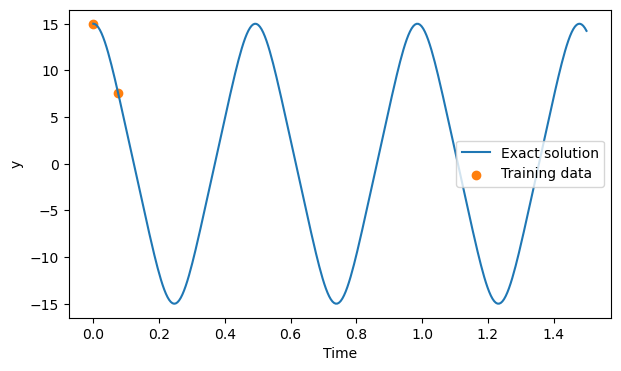

In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from scipy.integrate import odeint
import matplotlib.pyplot as plt

alpha = 1.0
beta = 1.0

def model(Y, t, alpha, beta):
    x, y = Y
    dxdt = y
    dydt = -alpha * x - beta * x**3
    return [dxdt, dydt]

x0 = 15         # x(0)
y0 = 0          # dx/dt(0)
Y0 = [x0, y0]

t = np.linspace(0, 1.5, 300)
solution = odeint(model, Y0, t, args=(alpha, beta))
t = torch.tensor(t, dtype=torch.float32).view(-1, 1) 
y = solution[:, 0]

t_data = torch.tensor(t[0:30:15], dtype=torch.float32).view(-1, 1)
y_data = torch.tensor(y[0:30:15], dtype=torch.float32).view(-1, 1)

plt.figure(figsize=(7, 4))
plt.plot(t, y, label="Exact solution")
plt.scatter(t_data, y_data, color="tab:orange", label="Training data")
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Add energy conservation to solve Duffing oscillator

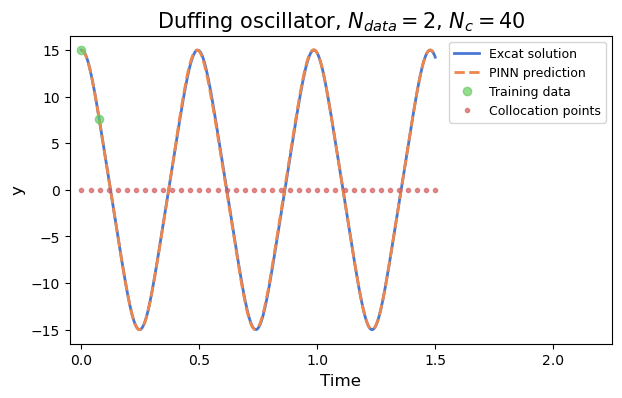

In [2]:
x_physics = torch.linspace(0,1.5,40).view(-1,1).requires_grad_(True)

torch.manual_seed(123)
model = FCN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1.1e-3)

loss1_history = []
loss2_history = []
loss_history = []

for i in range(48000):
    optimizer.zero_grad()
    
    yh = model(t_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]  # computes d^2y/dx^2    
    physics = (dx2 + alpha * yhp + beta * yhp**3)
    loss2 = (7.e-5) * torch.mean(physics**2)

    physics2 = ((dx**2/2 + alpha * yhp**2/2 + beta * yhp**4/4) - (alpha * x0**2 / 2 + beta * x0**4 / 4))
    loss3 = (1.e-6) * torch.mean((physics2)**2)
    
    loss = loss1 + loss2 + loss3
    loss.backward()
    optimizer.step()

y_pred = model(t).detach()

palette = sns.color_palette("muted")
num_domain = np.linspace(0, 1.5, 40)

plt.figure(figsize=(7, 4))
plt.plot(t, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(t, y_pred, '--', color=palette[1], linewidth=2, label='PINN prediction')
plt.plot(t_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.plot(num_domain, np.zeros_like(num_domain), '.', color=palette[3], linewidth=2, alpha=0.7, label='Collocation points')
plt.title('Duffing oscillator, $N_{data}=2$, $N_{c}=40$', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.xlim([-0.05, 2.25])
plt.show()

## No Enery conservation to solve Duffing oscillator

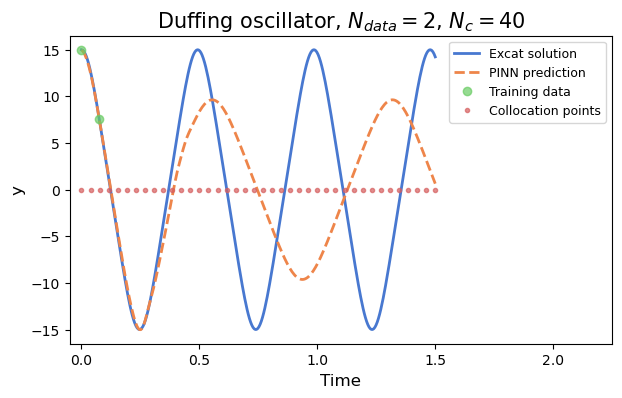

In [11]:
x_physics = torch.linspace(0,1.5,40).view(-1,1).requires_grad_(True)

torch.manual_seed(123)
model = FCN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1.1e-3)

loss1_history = []
loss2_history = []
loss_history = []

for i in range(48000):
    optimizer.zero_grad()
    
    yh = model(t_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]  # computes d^2y/dx^2    
    physics = (dx2 + alpha * yhp + beta * yhp**3)
    loss2 = (7.5e-4) * torch.mean(physics**2)
    
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

y_pred = model(t).detach()

palette = sns.color_palette("muted")
num_domain = np.linspace(0, 1.5, 40)

plt.figure(figsize=(7, 4))
plt.plot(t, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(t, y_pred, '--', color=palette[1], linewidth=2, label='PINN prediction')
plt.plot(t_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.plot(num_domain, np.zeros_like(num_domain), '.', color=palette[3], linewidth=2, alpha=0.7, label='Collocation points')
plt.title('Duffing oscillator, $N_{data}=2$, $N_{c}=40$', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.xlim([-0.05, 2.25])
plt.show()